In [103]:

from datetime import datetime, timedelta, date
from calendar import monthrange
from typing import List, Tuple
from ast import Dict
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cdsapi
import utils
import whittaker_smooth as ws
import numpy as np
from scipy import stats
import statsmodels.api as sm


## API parameters for temperature and precipitation extraction

In [104]:
def images_time_info(
    img_keys: List[str],
    initial_date,
) -> Tuple [List, List, List]:
    """
    Changes the images dates to the natural number day after query begins.
    Returns list of natural number days, list of dates, list of hours.
    Initial date must be in datetime.date(Y,m,d) format.
    """
    # Lists of dates, hours and timestamps.
    dates_list = []
    hours_list = []
    timestamps_list = []
    # Iterate over the key list.
    for image_details in img_keys:
        # Parse the date from the key.
        date = pd.to_datetime(image_details[0:15])
        day_format = date.strftime('%Y-%m-%d')
        dates_list.append(day_format)
        timestamps_list.append(date)
        # Hours from images retrieved
        hour_of_day = date.strftime('%H:%M')
        hours_list.append(hour_of_day)

    # Sorts.
    dates_list.sort()


    # List of numbers.
    initial_date = datetime(timestamps_list[0].year, initial_date.month, initial_date.day)
    # Calculate the differences between the initial and the nexts days.
    day_numbers = [datetime.strptime(day, '%Y-%m-%d') - initial_date for day in dates_list]
    # Get the difference in days.
    day_numbers = [day // timedelta(days=1) for day in day_numbers]

    return day_numbers, sorted(timestamps_list), hours_list


IMGS_PATH = ('D:\VSCode\Repositorios\Plant-Growth-Cycle-based-on-geospatial-data-1\DataExtraction\DataBase\Kansas-2022')
band_labels = ["B4", "B3", "B2", "B8"]
images = utils.load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())
initial_date=date(2019, 4, 1)
days, timestamps_list, hours_list = images_time_info(img_keys, initial_date)

In [105]:

start_dt = date(2019, 4, 1)
end_dt   = date(2021,12, 1)

#Function that returns a the days between two dates (the inicial date and the las date)
def date_range(date_min, date_max):
    #GWe generate a for to iterate through the correct range of dates.
    for difference_between_dates in range(int ((date_max - date_min).days)+1):
        #Use yield to return the dates given by the difference starting at date_min and ending at date_max
        yield date_min + timedelta(difference_between_dates)


#Create the list for the data(year,month,day,hour)
year_list=[]
month_list=[]
day_list=[]
hour_list=[]

#En este for se generan las listas
for dt in date_range(start_dt, end_dt):
    year_list.append((dt.strftime("%Y")))
    month_list.append((dt.strftime("%m")))
    day_list.append((dt.strftime("%d")))
    hour_list.append((dt.strftime("%H:%M")))
#Lists corresponding to the api data sorted and correctly formatted
    
list_year=(','.join(sorted(set(year_list))))
list_month=(','.join(sorted(set(month_list))))
list_day=(','.join(sorted(set(day_list))))
list_hour=(','.join(sorted(set(hour_list))))

## Temperature and precipitation extraction from API

In [106]:
#url: https://cds.climate.copernicus.eu/api/v2
#key: 159276:b225e1d7-1242-4152-8576-ce50852fbd4e

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            'soil_temperature_level_1', 'total_precipitation',
        ],
        'year': sorted(set(year_list))
        ,
        'month': sorted(set(month_list))
        ,
        'day': sorted(set(day_list))
        ,
        'time': [
            '17:00', 
            
        ],
        'area': [
            
            # Kansas:
            38.1445082027146, -97.72654627101196, 38.142173460759004, -97.72096882266754, 
            
            # Manitoba:
            #49.487637,-98.193971,49.480258,-98.182759,
        ],
        'format': 'netcdf',
    },
    'download.nc')

# MUST SOLVE: IF OSError WITH FILE download1.nc, rename the file or try deleting it, needs softcoding 

2022-11-04 10:32:12,998 INFO Welcome to the CDS
2022-11-04 10:32:13,000 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-11-04 10:32:13,208 INFO Request is completed
2022-11-04 10:32:13,210 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data1/adaptor.mars.internal-1667491234.3777988-4710-9-ddc08237-91b0-4a85-934e-3ba107335cf5.nc to download.nc (9.9K)
2022-11-04 10:32:13,985 INFO Download rate 12.8K/s


Result(content_length=10140,content_type=application/x-netcdf,location=https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data1/adaptor.mars.internal-1667491234.3777988-4710-9-ddc08237-91b0-4a85-934e-3ba107335cf5.nc)

In [107]:
# Open dataset
data_tp=xr.open_dataset('download1.nc')

# Polynomial regression
In this next section we develop the linear regression forecasting model.
1. NDVI data extraction
2. Features extraction (temperature, precipitation)
3. Building regression model and analysis based on 2019 data
4. Forecasting with 2020 features data

## 1. NDVI data extraction

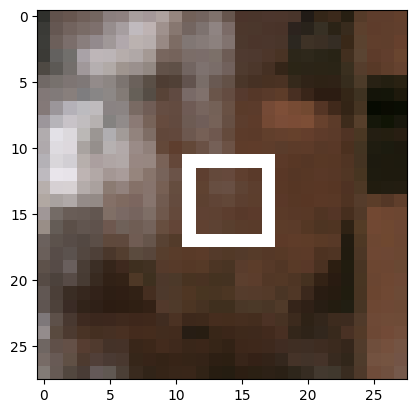

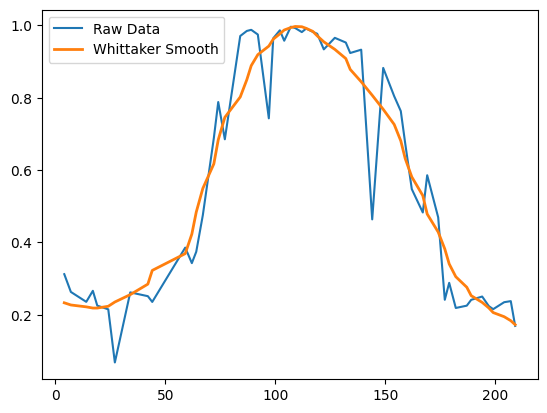

In [108]:
#Loading Data
location="Kansas"
year = "2019"
initial_date = date(2019,4,1)
IMGS_PATH = ('D:\VSCode\Repositorios\Plant-Growth-Cycle-based-on-geospatial-data-1\DataExtraction\DataBase\\'+location+'-'+year)
band_labels = ["B4", "B3", "B2", "B8"]
images = utils.load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())
days,dates,hours = utils.images_time_info(img_keys,initial_date)

#Calculations

##NDVI
ndvi_ts = utils.generate_ndvi_time_series(images=images)

##NDVI curve smoothing
clean_ndvi = ws.whittaker_smooth(np.array(ndvi_ts),lmbd=100,d=2)

##Boxcox Transformation
fitted_data, fitted_lambda = stats.boxcox(clean_ndvi)

##Plotting 
plt.figure()
plt.plot(days,ndvi_ts,label="Raw Data") 
plt.plot(days,clean_ndvi,linewidth=2,label="Whittaker Smooth")
#plt.plot(fitted_data,label="Box-Cox")
plt.legend()


## 2. Features data extraction

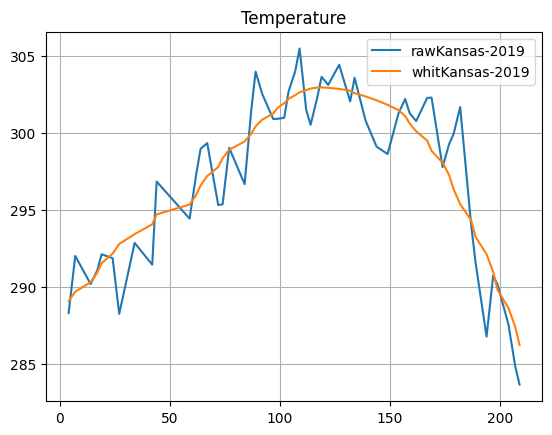

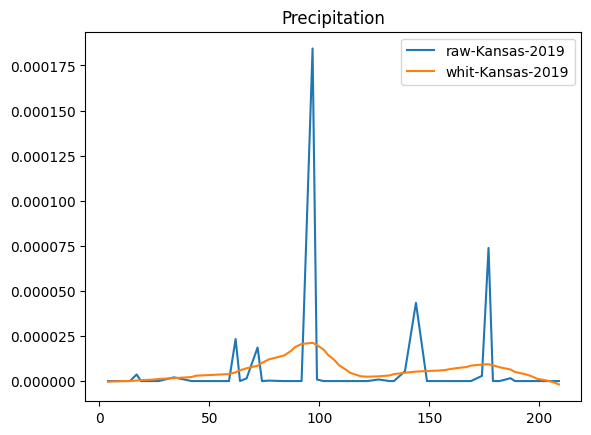

In [109]:
# Temperature and precipitation arrays
location="Kansas"
years = ["2019","2020","2021"]
all_temp=[]
all_preci=[]
temp_preci_dict = utils.data_extractor_temp(data_tp,[int(year) for year in years])
IMGS_PATH = ('D:\VSCode\Repositorios\Plant-Growth-Cycle-based-on-geospatial-data-1\DataExtraction\DataBase\\'+location+'-'+year)
band_labels = ["B4", "B3", "B2", "B8"]
images = utils.load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())
days, timestamps_list, hours_list = utils.images_time_info(img_keys,initial_date)

# Creates dictionary with all data
# Retrieves specific values according to images
temp,preci = utils.get_temp_and_preci(temp_preci_dict, timestamps_list)
all_temp.extend(temp)
all_preci.extend(preci)
##Features curve smoothing
clean_temp = ws.whittaker_smooth(np.array(temp),lmbd=1000,d=2)
clean_preci = ws.whittaker_smooth(np.array(preci),lmbd=100,d=2)

plt.figure(1)
plt.title("Temperature")
plt.plot(days,temp,label='raw'+location+'-'+year)
plt.plot(days,clean_temp,label='whit'+location+'-'+year)
plt.grid()
plt.legend()

plt.figure(2)
plt.title("Precipitation")
plt.plot(days,preci,label='raw-'+location+'-'+year)
plt.plot(days,clean_preci,label='whit-'+location+'-'+year)
plt.legend()

## 3. Regression model and analysis
Creation of a model based on 2019 temperature data.

coefficient of determination: 0.929787531505715


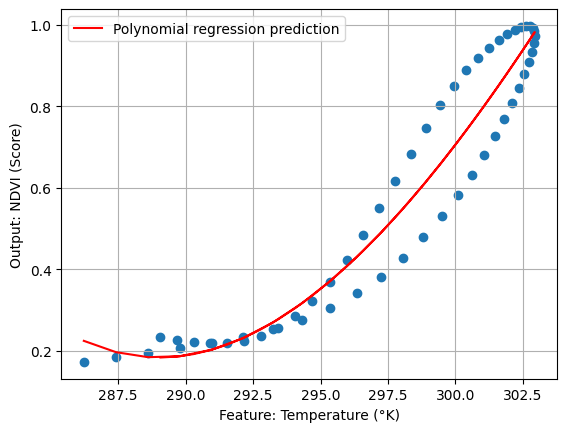

In [110]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Reshape to apply function (x must have a column per y value)
x = clean_temp.reshape((-1,1))
y = clean_ndvi
plt.figure()
plt.scatter(x,y)

# Transform to apply LinearRegression function
transformer = PolynomialFeatures(degree=3, include_bias=False)
transformer.fit(x)
x_ = transformer.transform(x)

# Apply the model to our transformed x
model_2019 = LinearRegression().fit(x_, y)
y_predict = model_2019.predict(x_)

r_sq = model_2019.score(x_, y)
print(f"coefficient of determination: {r_sq}")


plt.plot(x,y_predict,'r',label="Polynomial regression prediction")
plt.ylabel("Output: NDVI (Score)")
plt.xlabel("Feature: Temperature (°K)")
plt.grid()
plt.legend()



## 4. Prediction trial for 2020 temperature
Using model_2019 based to predict.

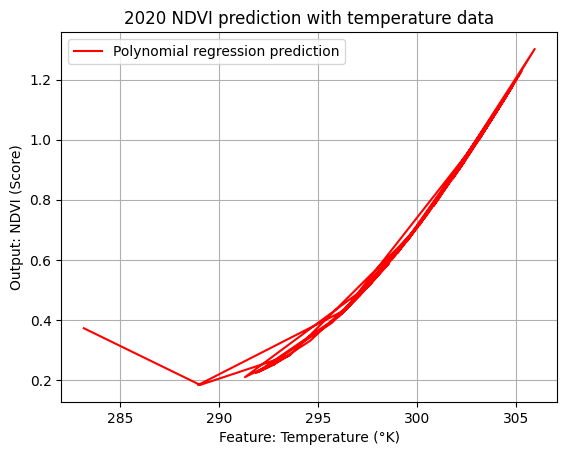

In [114]:

# IMPORTANTE: HARDCODEE PARA QUE FUERAN 56 VALORES, SE TIENEN QUE TENER MISMOS VALORES QUE EL MODELO (temp_2020 y model_2019)
# This data can be automatically obtain from features extraction section 
temp_2020 = np.array([283.1513671875, 289.03173828125, 
293.5457763671875, 291.2962646484375, 297.69195556640625, 294.6043395996094, 292.71337890625, 
292.75775146484375, 291.84521484375, 296.10162353515625, 298.845703125, 302.2131652832031, 
304.745361328125, 304.45263671875, 300.1196594238281, 303.5379638671875, 304.7825927734375, 
304.5750427246094, 301.0665588378906, 300.8268127441406, 305.9427795410156, 303.1600646972656, 
304.00531005859375, 304.8019104003906, 305.2742919921875, 303.05841064453125, 304.3760681152344, 
304.3102111816406, 304.8591613769531, 300.0223388671875, 295.9878234863281, 300.4503173828125, 
302.39495849609375, 299.494140625, 304.18853759765625, 302.7628173828125, 301.8044738769531, 
303.1278381347656, 304.5406799316406, 303.9774169921875, 299.01031494140625, 299.62939453125, 
303.2652587890625, 296.1610107421875, 298.5472412109375, 296.16888427734375, 297.0857238769531, 
299.902099609375, 293.60089111328125, 292.72198486328125, 292.0062561035156, 295.6786193847656, 
297.631103515625, 298.5773010253906, 296.42010498046875, 288.9350891113281])

# Transform to apply LinearRegression function
x = temp_2020.reshape((-1,1))
transformer = PolynomialFeatures(degree=3, include_bias=False)
transformer.fit(x)
x_ = transformer.transform(x)

# Prediction of NDVI with model from 2019
y_2020 = model_2019.predict(x_)

# Temperature vs. NDVI
plt.plot(x,y_2020,'r',label="Polynomial regression prediction")
plt.ylabel("Output: NDVI (Score)")
plt.xlabel("Feature: Temperature (°K)")
plt.grid()
plt.title("2020 NDVI prediction with temperature data")
plt.legend()


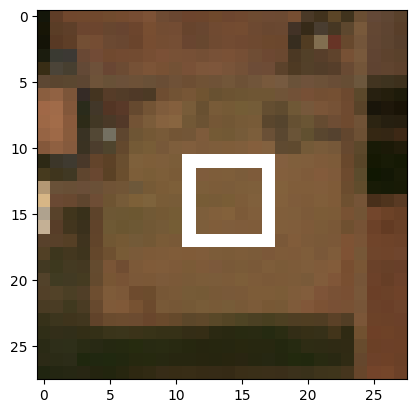

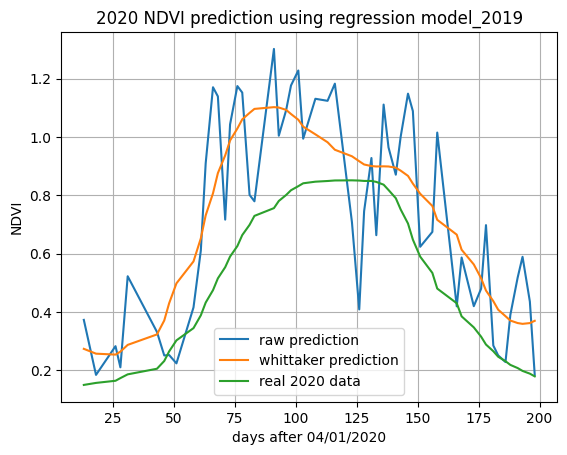

In [120]:
# Whittaker smoothing and prediction plot NDVI time series of next year
prediction_ndvi_2020 = ws.whittaker_smooth(np.array(y_2020),lmbd=1000,d=3)

IMGS_PATH = ('D:\VSCode\Repositorios\Plant-Growth-Cycle-based-on-geospatial-data-1\DataExtraction\DataBase\\'+location+'-'+'2020')
band_labels = ["B4", "B3", "B2", "B8"]
images = utils.load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())
days,dates,hours = utils.images_time_info(img_keys,initial_date)

days=days[3:59]
#Calculations
##NDVI
real_ndvi_2020 = utils.generate_ndvi_time_series(images=images)[3:59]

##NDVI curve smoothing
real_ndvi_2020 = ws.whittaker_smooth(np.array(real_ndvi_2020),lmbd=100,d=2)
plt.figure()
plt.title("2020 NDVI prediction using regression model_2019")
plt.grid()
plt.plot(days,y_2020, label="raw prediction")
plt.plot(days,prediction_ndvi_2020, label = "whittaker prediction")
plt.plot(days,real_ndvi_2020, label = "real 2020 data")
plt.xlabel("days after 04/01/2020")
plt.ylabel("NDVI")
plt.legend()

# Quick analysis
Even though amplitud graph are not the same, cycle stages sizes seem similar. (MUST STUDY)

# Near future development for regression
1. This was made using LinearRegression based on a polynomial regression, we should try nonlinear regression methods.
2. This is considering one variable (Temperature) solely because punctual data from precipitation didn't fullfill regression conditions.
3. Must use splines to have same size data between next years data and prediction model.
4. Perhaps instead of using specific data of features and using all year data of features give better results.
